# Liver segmentations

In [ ]:
#imports
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt

# Set numpy print options to avoid truncation
#np.set_printoptions(threshold=np.inf)

In [ ]:
#use first image as example

#12 and 13 are liver
#image and segmentation have the same affine matrix
#did not yet update affine and header (not necessary?)

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last scan niftis cropped"
segmentations_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last segmentations cropped"

#load first image and segmentation
image = nib.load(os.path.join(scans_path, "CAESAR001_1_0000.nii.gz"))
segmentation = nib.load(os.path.join(segmentations_path, "CAESAR001_1.nii.gz"))

image_data = image.get_fdata()
segmentation_data = segmentation.get_fdata()

liver_mask = (segmentation_data == 12) | (segmentation_data == 13)

#apply mask to image
liver_image = np.copy(image_data)
liver_image[~liver_mask] = 0

# Find the indices of the liver mask
mask_indices = np.argwhere(liver_mask)

# Calculate the bounding box
min_indices = mask_indices.min(axis=0)
max_indices = mask_indices.max(axis=0)

print(min_indices, max_indices)

# Crop the liver image using the bounding box
cropped_liver_image = liver_image[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
#print(cropped_liver_image.shape)
#padd with required number of zeros to correct size


# # Create a new NIfTI image
new_image = nib.Nifti1Image(cropped_liver_image, affine=image.affine, header=image.header)

# # Save the new NIfTI image to a file
output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations/test_liver_image.nii.gz"
nib.save(new_image, output_path)

# Display multiple plots
# for i in range(cropped_liver_image.shape[2]):
#     plt.figure()  # Create a new figure for each slice
#     plt.imshow(cropped_liver_image[:, :, i], cmap='gray')
#     plt.title(f'Slice {i}')
#     plt.axis('off')
#     plt.show()

### Distribution of number of slices

In [44]:
#distribution of slices
scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last scan niftis cropped"

max_slices = 0

number_of_slices = []
for scan in os.listdir(scans_path):
    image = nib.load(os.path.join(scans_path, scan))
    image_shape = image.header.get_data_shape()
    max_slices = max(max_slices, image_shape[2])    
    if image_shape[2] < 150:
        number_of_slices.append(image_shape[2])

print(len(number_of_slices))
print(max_slices)
#plt.hist(number_of_slices)
#plt.show() 

328
376


### Create segmentation and bounding box

In [ ]:
#does not update affine and header

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last scan niftis cropped"
segmentations_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last segmentations cropped"
output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"

max_dimensions = [0, 0, 0]

for scan in os.listdir(scans_path):
    print(scan)
    
    #load image and corresponding segmentation
    image = nib.load(os.path.join(scans_path, scan))

    segm_filename = scan.replace("_0000", "")
    segmentation = nib.load(os.path.join(segmentations_path, segm_filename))

    image_data = image.get_fdata()
    segmentation_data = segmentation.get_fdata()

    liver_mask = (segmentation_data == 12) | (segmentation_data == 13)

    #apply mask to image
    liver_image = np.copy(image_data)
    liver_image[~liver_mask] = 0

    # Find the indices of the liver mask
    mask_indices = np.argwhere(liver_mask)

    # Calculate the bounding box
    min_indices = mask_indices.min(axis=0)
    max_indices = mask_indices.max(axis=0)

    # Crop the liver image using the bounding box
    cropped_liver_image = liver_image[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
    
    # Update the maximum dimensions
    max_dimensions = np.maximum(max_dimensions, cropped_liver_image.shape)

    # Create a new NIfTI image
    new_image = nib.Nifti1Image(cropped_liver_image, affine=image.affine, header=image.header)

    # Save the new NIfTI image to a file with the original name
    new_filename = scan.split(".")[0] + "_cropped.nii.gz"
    output_file_path = os.path.join(output_path, new_filename)
    nib.save(new_image, output_file_path)

print(max_dimensions)

CAESAR001_1_0000.nii.gz
CAESAR004_1_0000.nii.gz
CAESAR007_1_0000.nii.gz
CAESAR010_1_0000.nii.gz
CAESAR011_2_0000.nii.gz
CAESAR012_1_0000.nii.gz
CAESAR013_2_0000.nii.gz
CAESAR014_1_0000.nii.gz
CAESAR015_1_0000.nii.gz
CAESAR017_1_0000.nii.gz
CAESAR018_2_0000.nii.gz
CAESAR021_1_0000.nii.gz
CAESAR022_2_0000.nii.gz
CAESAR026_1_0000.nii.gz
CAESAR027_1_0000.nii.gz
CAESAR028_1_0000.nii.gz
CAESAR029_1_0000.nii.gz
CAESAR030_1_0000.nii.gz
CAESAR032_1_0000.nii.gz
CAESAR033_2_0000.nii.gz
CAESAR034_1_0000.nii.gz
CAESAR036_1_0000.nii.gz
CAESAR037_1_0000.nii.gz
CAESAR038_1_0000.nii.gz
CAESAR041_1_0000.nii.gz
CAESAR043_1_0000.nii.gz
CAESAR044_1_0000.nii.gz
CAESAR045_1_0000.nii.gz
CAESAR046_1_0000.nii.gz
CAESAR047_2_0000.nii.gz
CAESAR048_1_0000.nii.gz
CAESAR049_1_0000.nii.gz
CAESAR050_1_0000.nii.gz
CAESAR051_1_0000.nii.gz
CAESAR052_1_0000.nii.gz
CAESAR053_1_0000.nii.gz
CAESAR054_1_0000.nii.gz
CAESAR055_1_0000.nii.gz
CAESAR057_1_0000.nii.gz
CAESAR058_1_0000.nii.gz
CAESAR061_1_0000.nii.gz
CAESAR062_1_0000

In [ ]:
#check the shape of every image
scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"

first_dim = []
second_dim = []
third_dim = []
max_slices = 0

for scan in os.listdir(scans_path):
    image = nib.load(os.path.join(scans_path, scan))
    image_data = image.get_fdata()
    first_dim.append(image_data.shape[0])
    second_dim.append(image_data.shape[1])
    third_dim.append(image_data.shape[2])
    max_slices = max(max_slices, image_data.shape[2])

print(max_slices)


366


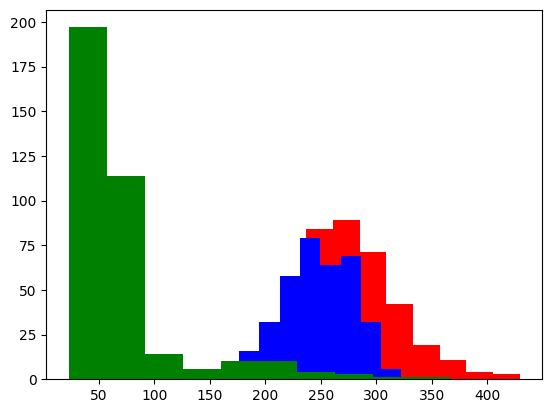

In [42]:
plt.hist(first_dim, color='red')
plt.hist(second_dim, color='blue')
plt.hist(third_dim, color='green')
plt.show()

In [ ]:
test = [429, 341, 366]
test 

TypeError: can only concatenate list (not "int") to list

### Add appropriate padding for every scan

In [ ]:
boundingbox_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"
padded_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/padded_liver_segmentations"

#largest dimensions of all images
max_dimensions = [0, 0, 0]

for scan in os.listdir(boundingbox_segm_path):
    #load image
    image = nib.load(os.path.join(boundingbox_segm_path, scan))

    image_data = image.get_fdata()
    liver_image = np.copy(image_data)
    #biggest image is: [429, 341, 366]

        # Calculate the padding widths for each dimension
    pad_widths = [(0, max_dim - curr_dim) for max_dim, curr_dim in zip(max_dimensions, liver_image.shape)]

    # Pad the liver image with zeros to the desired size
    padded_liver_image = np.pad(liver_image, pad_widths, mode='constant', constant_values=0)

    #perhaps change image header (and affine)

    # Create a new NIfTI image
    new_image = nib.Nifti1Image(liver_image, affine=image.affine, header=image.header)

    # Save the new NIfTI image to a file with the original name
    output_file_path = os.path.join(padded_segm_path, scan)
    nib.save(new_image, output_file_path)

    #show image using matplotlib
    #plt.imshow(liver_image[:, :, 40], cmap='gray')
    break

